In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2,cv2

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
pycocotools 2.0.2
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101
detectron2 0.2.1
cv2 4.4.0


In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
from urllib import request
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [16]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

AttributeError: InlineBackend

In [18]:
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT, K12AI_NBDATA_ROOT, K12AI_PRETRAINED_ROOT
from k12libs.utils.nb_easy import k12ai_set_notebook
k12ai_set_notebook(cellw=95)

## Read Data

In [19]:
dataset = 'faces'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
imgs_path = os.path.join(data_root, "imgs")
output_dir = os.path.join(K12AI_NBDATA_ROOT, 'cv', 'det', 'ouput')

df = pd.read_csv(os.path.join(data_root, 'annotations.csv'),)
df.head()

,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,face_0.jpeg,650,333,56,102,112,151,face
1,face_0.jpeg,650,333,379,97,428,156,face
2,face_1.jpeg,1280,697,903,162,985,252,face
3,face_2.jpeg,460,240,216,12,279,80,face
4,face_2.jpeg,460,240,289,2,343,74,face


## Train/Val Sample

In [6]:
unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.8), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,face_0.jpeg,650,333,56,102,112,151,face
1,face_0.jpeg,650,333,379,97,428,156,face
3,face_2.jpeg,460,240,216,12,279,80,face
4,face_2.jpeg,460,240,289,2,343,74,face
5,face_3.jpeg,600,291,297,79,357,134,face


In [7]:
classes = df.class_name.unique().tolist()
classes

['face']

In [20]:
def create_dataset_dicts(df, classes):
    dataset_dicts = []
    for image_id, img_name in enumerate(df.file_name.unique()):

        record = {}

        image_df = df[df.file_name == img_name]

        file_path = f'{imgs_path}/{img_name}'
        # if not os.path.exists(file_path):
        #     print(file_path)
        record["file_name"] = file_path
        record["image_id"] = image_id
        record["height"] = int(image_df.iloc[0].height)
        record["width"] = int(image_df.iloc[0].width)

        objs = []
        for _, row in image_df.iterrows():

            xmin = int(row.x_min)
            ymin = int(row.y_min)
            xmax = int(row.x_max)
            ymax = int(row.y_max)

            poly = [
                (xmin, ymin), (xmax, ymin), 
                (xmax, ymax), (xmin, ymax)
            ]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(row.class_name),
                "iscrowd": 0
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [21]:
len(train_df.file_name.unique()), len(test_df.file_name.unique())

(327, 82)

In [10]:
for d in ["train", "val"]:
    DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
    MetadataCatalog.get("faces_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("faces_train")
statement_metadata

namespace(name='faces_train', thing_classes=['face'])

In [22]:
class CocoTrainer(DefaultTrainer):
  
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        os.makedirs(output_dir, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, distributed=False, output_dir=output_dir)

In [23]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = os.path.join(f'{K12AI_PRETRAINED_ROOT}/cv/model_zoo/model_final_68b088.pkl')

cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

cfg.OUTPUT_DIR = output_dir

os.makedirs(output_dir, exist_ok=True)

In [13]:
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[09/08 20:10:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/08 20:10:39 d2.data.build]: Removed 0 images with no usable annotations. 327 images left.
[09/08 20:10:39 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    face    | 900          |
|            |              |
[09/08 20:10:39 d2.data.common]: Serializing 327 elements to byte tensors and concatenating them all ...
[09/08 20:10:39 d2.data.common]: Serialized dataset takes 0.12 MiB
[09/08 20:10:39 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/08 20:10:39 d2.data.build]: Using training sampler TrainingSampler


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[09/08 20:10:40 d2.engine.train_loop]: Starting training from iteration 0
[09/08 20:11:20 d2.utils.events]:  eta: 0:48:49  iter: 19  total_loss: 1.944  loss_cls: 0.5515  loss_box_reg: 0.4322  loss_mask: 0.6925  loss_rpn_cls: 0.1941  loss_rpn_loc: 0.02286  time: 1.9662  data_time: 0.0373  lr: 1.9981e-05  max_mem: 11287M
[09/08 20:11:59 d2.utils.events]:  eta: 0:48:15  iter: 39  total_loss: 1.919  loss_cls: 0.5188  loss_box_reg: 0.6056  loss_mask: 0.6761  loss_rpn_cls: 0.1339  loss_rpn_loc: 0.01838  time: 1.9558  data_time: 0.0177  lr: 3.9961e-05  max_mem: 11287M
[09/08 20:12:39 d2.utils.events]:  eta: 0:47:46  iter: 59  total_loss: 1.754  loss_cls: 0.4604  loss_box_reg: 0.5554  loss_mask: 0.6423  loss_rpn_cls: 0.09693  loss_rpn_loc: 0.02465  time: 1.9673  data_time: 0.0151  lr: 5.9941e-05  max_mem: 11287M
[09/08 20:13:18 d2.utils.events]:  eta: 0:47:10  iter: 79  total_loss: 2.03  loss_cls: 0.4751  loss_box_reg: 0.8642  loss_mask: 0.611  loss_rpn_cls: 0.05337  loss_rpn_loc: 0.02014  tim

[09/08 20:27:28 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.03 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | m

[09/08 20:39:18 d2.utils.events]:  eta: 0:21:22  iter: 859  total_loss: 0.8921  loss_cls: 0.1525  loss_box_reg: 0.4381  loss_mask: 0.2985  loss_rpn_cls: 0.001536  loss_rpn_loc: 0.01167  time: 1.9692  data_time: 0.0207  lr: 0.00085914  max_mem: 11287M
[09/08 20:39:58 d2.utils.events]:  eta: 0:20:43  iter: 879  total_loss: 0.9076  loss_cls: 0.1575  loss_box_reg: 0.4171  loss_mask: 0.3095  loss_rpn_cls: 0.003301  loss_rpn_loc: 0.01029  time: 1.9692  data_time: 0.0183  lr: 0.00087912  max_mem: 11287M
[09/08 20:40:37 d2.utils.events]:  eta: 0:20:03  iter: 899  total_loss: 0.907  loss_cls: 0.1686  loss_box_reg: 0.4147  loss_mask: 0.312  loss_rpn_cls: 0.001922  loss_rpn_loc: 0.01044  time: 1.9695  data_time: 0.0190  lr: 0.0008991  max_mem: 11287M
[09/08 20:41:17 d2.utils.events]:  eta: 0:19:22  iter: 919  total_loss: 0.8719  loss_cls: 0.1537  loss_box_reg: 0.4181  loss_mask: 0.2905  loss_rpn_cls: 0.001422  loss_rpn_loc: 0.01057  time: 1.9694  data_time: 0.0206  lr: 0.00091908  max_mem: 11287M

[09/08 20:48:11 d2.utils.events]:  eta: 0:12:43  iter: 1119  total_loss: 0.6737  loss_cls: 0.1138  loss_box_reg: 0.2901  loss_mask: 0.2529  loss_rpn_cls: 0.0005335  loss_rpn_loc: 0.009797  time: 1.9709  data_time: 0.0187  lr: 5e-05  max_mem: 11287M
[09/08 20:48:50 d2.utils.events]:  eta: 0:12:03  iter: 1139  total_loss: 0.7045  loss_cls: 0.1187  loss_box_reg: 0.3094  loss_mask: 0.2591  loss_rpn_cls: 0.0006502  loss_rpn_loc: 0.008227  time: 1.9703  data_time: 0.0198  lr: 5e-05  max_mem: 11287M
[09/08 20:49:31 d2.utils.events]:  eta: 0:11:23  iter: 1159  total_loss: 0.7061  loss_cls: 0.1069  loss_box_reg: 0.3078  loss_mask: 0.2544  loss_rpn_cls: 0.001562  loss_rpn_loc: 0.01018  time: 1.9713  data_time: 0.0180  lr: 5e-05  max_mem: 11287M
[09/08 20:50:10 d2.utils.events]:  eta: 0:10:43  iter: 1179  total_loss: 0.7277  loss_cls: 0.1252  loss_box_reg: 0.3194  loss_mask: 0.2622  loss_rpn_cls: 0.001375  loss_rpn_loc: 0.00989  time: 1.9715  data_time: 0.0178  lr: 5e-05  max_mem: 11287M
[09/08 2

[09/08 21:01:00 d2.engine.defaults]: Evaluation results for faces_val in csv format:
[09/08 21:01:00 d2.evaluation.testing]: copypaste: Task: bbox
[09/08 21:01:00 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/08 21:01:00 d2.evaluation.testing]: copypaste: 25.4941,66.8140,16.8095,6.7751,17.9128,31.2676
[09/08 21:01:00 d2.evaluation.testing]: copypaste: Task: segm
[09/08 21:01:00 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/08 21:01:00 d2.evaluation.testing]: copypaste: 23.9513,66.9228,15.9837,4.2629,15.5273,30.2876
[09/08 21:01:00 d2.utils.events]:  eta: 0:00:02  iter: 1499  total_loss: 0.6177  loss_cls: 0.09345  loss_box_reg: 0.2645  loss_mask: 0.2448  loss_rpn_cls: 0.000778  loss_rpn_loc: 0.009389  time: 1.9712  data_time: 0.0190  lr: 5e-05  max_mem: 11288M
[09/08 21:01:00 d2.engine.hooks]: Overall training speed: 1497 iterations in 0:49:12 (1.9726 s / it)
[09/08 21:01:00 d2.engine.hooks]: Total training time: 0:50:15 (0:01:02 on hooks)


In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

In [25]:
evaluator = COCOEvaluator("faces_val", cfg, False, output_dir=output_dir)
val_loader = build_detection_test_loader(cfg, "faces_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/08 21:17:37 d2.data.common]: Serializing 82 elements to byte tensors and concatenating them all ...
[09/08 21:17:37 d2.data.common]: Serialized dataset takes 0.03 MiB
[09/08 21:17:37 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/08 21:17:37 d2.evaluation.evaluator]: Start inference on 82 images
[09/08 21:17:39 d2.evaluation.evaluator]: Inference done 11/82. 0.1771 s / img. ETA=0:00:13
[09/08 21:17:44 d2.evaluation.evaluator]: Inference done 34/82. 0.1879 s / img. ETA=0:00:10
[09/08 21:17:49 d2.evaluation.evaluator]: Inference done 59/82. 0.1882 s / img. ETA=0:00:04
[09/08 21:17:54 d2.evaluation.evaluator]: Inference done 80/82. 0.1899 s / img. ETA=0:00:00
[09/08 21:17:55 d2.evaluation.evaluator]: Total inference time: 0:00:16.877306 (0.219186 s / img per device, on 1 devices)
[09/08 21:17:55 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:14 (0.189925 s / img pe

OrderedDict([('bbox',
              {'AP': 25.49410696812321,
               'AP50': 66.81399560367917,
               'AP75': 16.80948193109004,
               'APs': 6.775106082036773,
               'APm': 17.91277677301344,
               'APl': 31.26756508357697}),
             ('segm',
              {'AP': 23.951278923825285,
               'AP50': 66.92282776994153,
               'AP75': 15.983669317110518,
               'APs': 4.262926292629262,
               'APm': 15.527308486999289,
               'APl': 30.287606686057067})])

In [26]:
test_image_paths = test_df.file_name.unique()
test_image_paths

array(['face_1.jpeg', 'face_13.jpeg', 'face_20.jpeg', 'face_21.jpeg',
       'face_34.jpeg', 'face_43.jpeg', 'face_48.jpeg', 'face_49.jpeg',
       'face_50.jpeg', 'face_52.jpeg', 'face_53.jpeg', 'face_54.jpeg',
       'face_58.jpeg', 'face_71.jpeg', 'face_80.jpeg', 'face_87.jpeg',
       'face_88.jpeg', 'face_91.jpeg', 'face_99.jpeg', 'face_102.jpeg',
       'face_105.jpeg', 'face_106.jpeg', 'face_121.jpeg', 'face_130.jpeg',
       'face_134.jpeg', 'face_149.jpeg', 'face_151.jpeg', 'face_160.jpeg',
       'face_161.jpeg', 'face_166.jpeg', 'face_169.jpeg', 'face_174.jpeg',
       'face_187.jpeg', 'face_188.jpeg', 'face_189.jpeg', 'face_190.jpeg',
       'face_191.jpeg', 'face_201.jpeg', 'face_205.jpeg', 'face_212.jpeg',
       'face_214.jpeg', 'face_217.jpeg', 'face_235.jpeg', 'face_241.jpeg',
       'face_243.jpeg', 'face_251.jpeg', 'face_252.jpeg', 'face_257.jpeg',
       'face_259.jpeg', 'face_263.jpeg', 'face_264.jpeg', 'face_269.jpeg',
       'face_270.jpeg', 'face_273.jpeg', 'fac

In [27]:
for clothing_image in test_image_paths[:2]:
    file_path = f'{imgs_path}/{clothing_image}'
    im = cv2.imread(file_path)
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=statement_metadata, 
        scale=1., 
        instance_mode=ColorMode.IMAGE
    )
    instances = outputs["instances"].to("cpu")
    instances.remove('pred_masks')
    v = v.draw_instance_predictions(instances)
    result = v.get_image()[:, :, ::-1]
    file_name = ntpath.basename(clothing_image)
    write_res = cv2.imwrite(f'{output_dir}/{file_name}', result)

In [36]:
annotated_images = [f'{output_dir}/{f}' for f in test_df.file_name.unique()]
annotated_images[:2]

['/data/nb_data/cv/det/ouput/face_1.jpeg',
 '/data/nb_data/cv/det/ouput/face_13.jpeg']

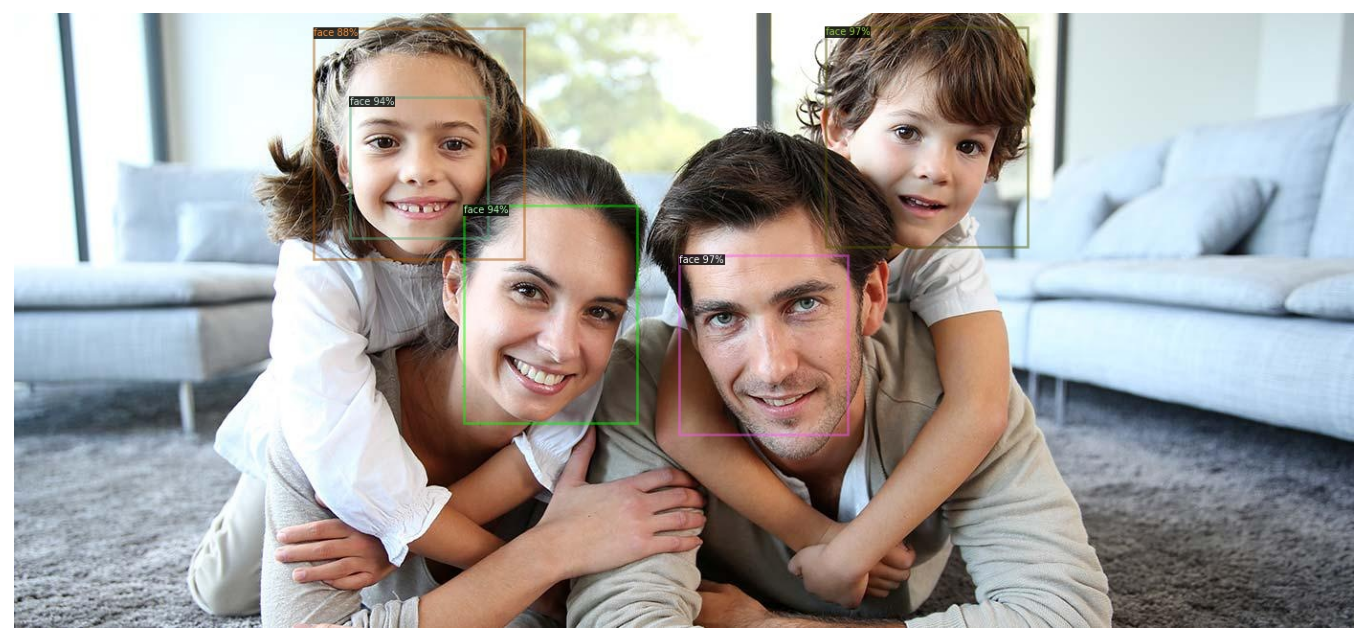

In [35]:
plt.figure(figsize=(12, 8))

img = cv2.cvtColor(cv2.imread(annotated_images[1]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

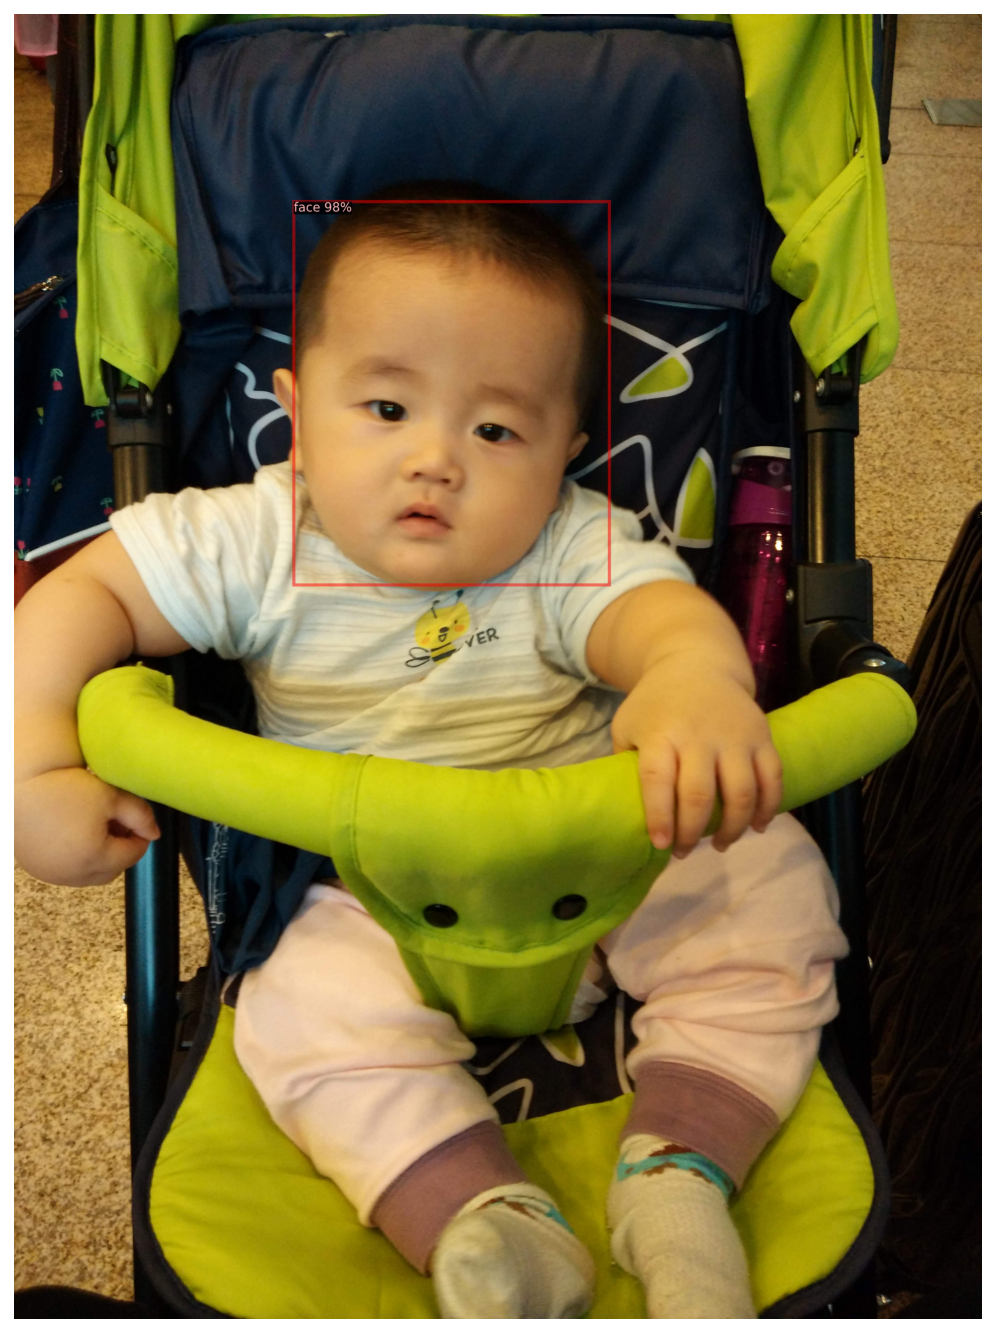

In [41]:
im = cv2.imread(f'{output_dir}/test.jpg')
outputs = predictor(im)
v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1., 
    instance_mode=ColorMode.IMAGE
)
instances = outputs["instances"].to("cpu")
instances.remove('pred_masks')
v = v.draw_instance_predictions(instances)
result = v.get_image()[:, :, ::-1]
cv2.imwrite(f'{output_dir}/test_det.jpg', result)

plt.figure(figsize=(12, 12))
img = cv2.cvtColor(cv2.imread(f'{output_dir}/test_det.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off');